# Machine Learning Methods for Diabetes Diagnosis: A Non-Glycemic Biomarker Exploration
### Master's thesis of the master's degree in Bioinformatics and Biostatistics of the UB and the UOC
- Author: Carlos Colmenero Gómez Cambronero

## Data pre-processing

### Import libraries

In [105]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Machine Learning - Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# Machine Learning - Sampling methods
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

# Parameter optimization
import optuna

### Load the data

In [106]:
# Load the data set
file_path = "data/Dataset of Diabetes.csv"
headers = pd.read_csv(file_path, nrows=0).columns.tolist()
data = pd.read_csv(file_path, usecols=headers[1:])
data.head()

,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


### Check the data types
There are 2 categorical variables (represented with objects), whereas the other variables are numeric, either integer (patient number, age and creatinine) or float (the remaining numerical variables).

In [107]:
data.dtypes

No_Pation      int64
Gender        object
AGE            int64
Urea         float64
Cr             int64
HbA1c        float64
Chol         float64
TG           float64
HDL          float64
LDL          float64
VLDL         float64
BMI          float64
CLASS         object
dtype: object

### Check the original shape of the data
The original data has 1000 observations (rows) and 13 columns (11 features plus the patient number and the diagnosis class)

In [108]:
data.shape

(1000, 13)

### Rename columns
Rename some columns to be more informative

In [109]:
data = data.rename(columns={'CLASS': 'Diagnosis',
                            'Gender': 'Sex',
                            'AGE': 'Age',
                            'No_Pation': 'Num_Patient'})

### Check missing values
There are no missing values in the dataset

In [110]:
# Check for missing values of each column
data.isna().sum()

Num_Patient    0
Sex            0
Age            0
Urea           0
Cr             0
HbA1c          0
Chol           0
TG             0
HDL            0
LDL            0
VLDL           0
BMI            0
Diagnosis      0
dtype: int64

### Check data consistency

Check if  the categories have been correctly labeled

In [111]:
# Split variables names by their type (categorical or numerical)
categorical_vars = [var for var in data.columns if (data[var].dtype == 'object')]
numerical_vars = [var for var in data.columns if (data[var].dtype in ['int64', 'float64']) and (var != 'Num_Patient')]

# Check the categories of categorical variables
for categorical_var in categorical_vars:
    print(f'{categorical_var}: {np.unique(data[categorical_var])}\n')

Sex: ['F' 'M' 'f']

Diagnosis: ['N' 'N ' 'P' 'Y' 'Y ']



There are some values that actually represent the same category due to accidental spaces or different capitalization. Thus, they will be unified.

In [112]:
# Unify the categories that refer to the same level
data['Sex'] = data['Sex'].str.replace('f', 'F')
data['Diagnosis'] = data['Diagnosis'].str.strip()

In [113]:
# Rename the categories to be more informative
data['Diagnosis'] = data['Diagnosis'].replace({'Y': 'Diabetes', 'N': 'Non-diabetes', 'P': 'Prediabetes'})
data['Sex'] = data['Sex'].replace({'M': 'Male', 'F': 'Female'})

In [114]:
# Check that the categories have been correctly unified and renamed
for categorical_var in categorical_vars:
    print(f'{categorical_var}: {np.unique(data[categorical_var])}\n')

Sex: ['Female' 'Male']

Diagnosis: ['Diabetes' 'Non-diabetes' 'Prediabetes']



Check if the patient number is unique

In [115]:
# Get the value counts
patient_number_counts = data['Num_Patient'].value_counts()

# Get the non-unique patient numbers
non_unique_patient_numbers = patient_number_counts[patient_number_counts > 1].index

# Filter the data for the non-unique patient numbers
data_non_unique_patient_numbers = data[data['Num_Patient'].isin(non_unique_patient_numbers)]

# Check the shape of the data with non-unique patient numbers
data_non_unique_patient_numbers['Num_Patient'].value_counts()

Num_Patient
454316    19
87654      2
34514      2
71741      2
48362      2
45370      2
34545      2
34518      2
34515      2
856        2
345        2
234        2
34290      2
44835      2
34516      2
2345       2
23972      2
34325      2
24033      2
14389      2
34517      2
45646      2
Name: count, dtype: int64

In [116]:
# Check the data of some non-unique patient numbers to see it their data is coherent
data_non_unique_patient_numbers[data_non_unique_patient_numbers['Num_Patient'] == 454316]

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis
96,454316,Female,54,6.3,106,5.6,4.3,2.0,1.3,2.2,0.9,20.0,Non-diabetes
97,454316,Female,50,3.3,70,4.9,3.7,0.9,1.2,2.7,0.6,24.0,Non-diabetes
98,454316,Male,60,7.5,70,0.9,3.4,5.3,1.1,3.6,0.8,24.0,Non-diabetes
99,454316,Male,77,5.0,106,5.4,0.0,2.8,0.8,1.8,0.7,19.0,Non-diabetes
100,454316,Female,59,4.7,58,4.1,4.5,1.8,1.8,1.8,1.3,22.5,Non-diabetes
101,454316,Female,57,4.6,97,0.9,3.2,1.3,0.9,3.0,1.1,22.0,Non-diabetes
981,454316,Male,65,5.0,97,7.0,4.3,4.3,1.4,1.5,2.0,27.0,Diabetes
982,454316,Female,54,5.0,88,6.8,5.1,2.1,1.1,3.0,1.0,30.0,Diabetes
983,454316,Male,64,8.8,106,8.5,5.9,2.1,1.2,4.0,1.2,32.0,Diabetes
984,454316,Female,60,5.0,70,8.1,5.2,3.3,1.4,0.6,3.0,27.0,Diabetes


In [117]:
data_non_unique_patient_numbers[data_non_unique_patient_numbers['Num_Patient'] == 87654]

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis
17,87654,Female,30,3.0,42,4.1,4.9,1.3,1.2,3.2,0.5,22.0,Non-diabetes
997,87654,Male,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Diabetes


The patient number, that should identify the patients, is not unique. If some observations with the same patient number are checked, it can be seen that the observations have values that are not compatible with each other (for instance, being female and male). Thus, the observations with the repeated patient numbers are considered mistakes and are deleted.

In [118]:
# Since the data is not coheret, remove the rows where the patient number is repeated
data = data[~data['Num_Patient'].isin(non_unique_patient_numbers)]

# Check the shape of the data after removing the rows with non-unique patient numbers
data.shape

(939, 13)

### Exploratory Data Analysis

 Show main statistics of numerical variables

In [119]:
data.drop('Num_Patient', axis=1).describe()

,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000
mean,53.373802,5.073464,67.168264,8.284984,4.849223,2.324505,1.208892,2.606486,1.873908,29.616954
std,8.707874,2.801364,51.137482,2.533044,1.286454,1.396236,0.677571,1.120413,3.746397,4.997534
min,20.000000,0.500000,6.000000,0.900000,0.500000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,51.000000,3.660000,48.000000,6.500000,4.000000,1.400000,0.900000,1.800000,0.700000,26.000000
50%,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


Check the frequency distribution of categorical variables

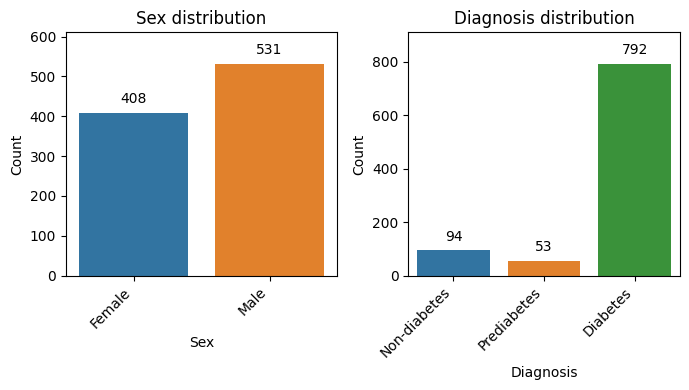

In [120]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# For each categorical variable
for i, var in enumerate(categorical_vars):

    # Plot the frequency distribution
    ax = sns.countplot(x=var, hue=var, data=data, ax=axes[i], legend=False)

    # Display the count above each bar
    for p in ax.patches:
        ax.annotate(round(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

    # Set the title and labels
    axes[i].set_title(var + ' distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

    # Rotate the x-axis labels for better visualization
    axes[i].tick_params(axis='x', rotation=45)
    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment('right')

    # Set the y-axis limit to a higher value
    axes[i].set_ylim([0, max([p.get_height() for p in ax.patches])*1.15])
    

# Adjust the layout
plt.tight_layout()

# Save the figure to SVG
fig.savefig('figures/categorical_variables_distribution.svg')

# Show the figure
plt.show()

Check the distribution of numerical variables through histograms

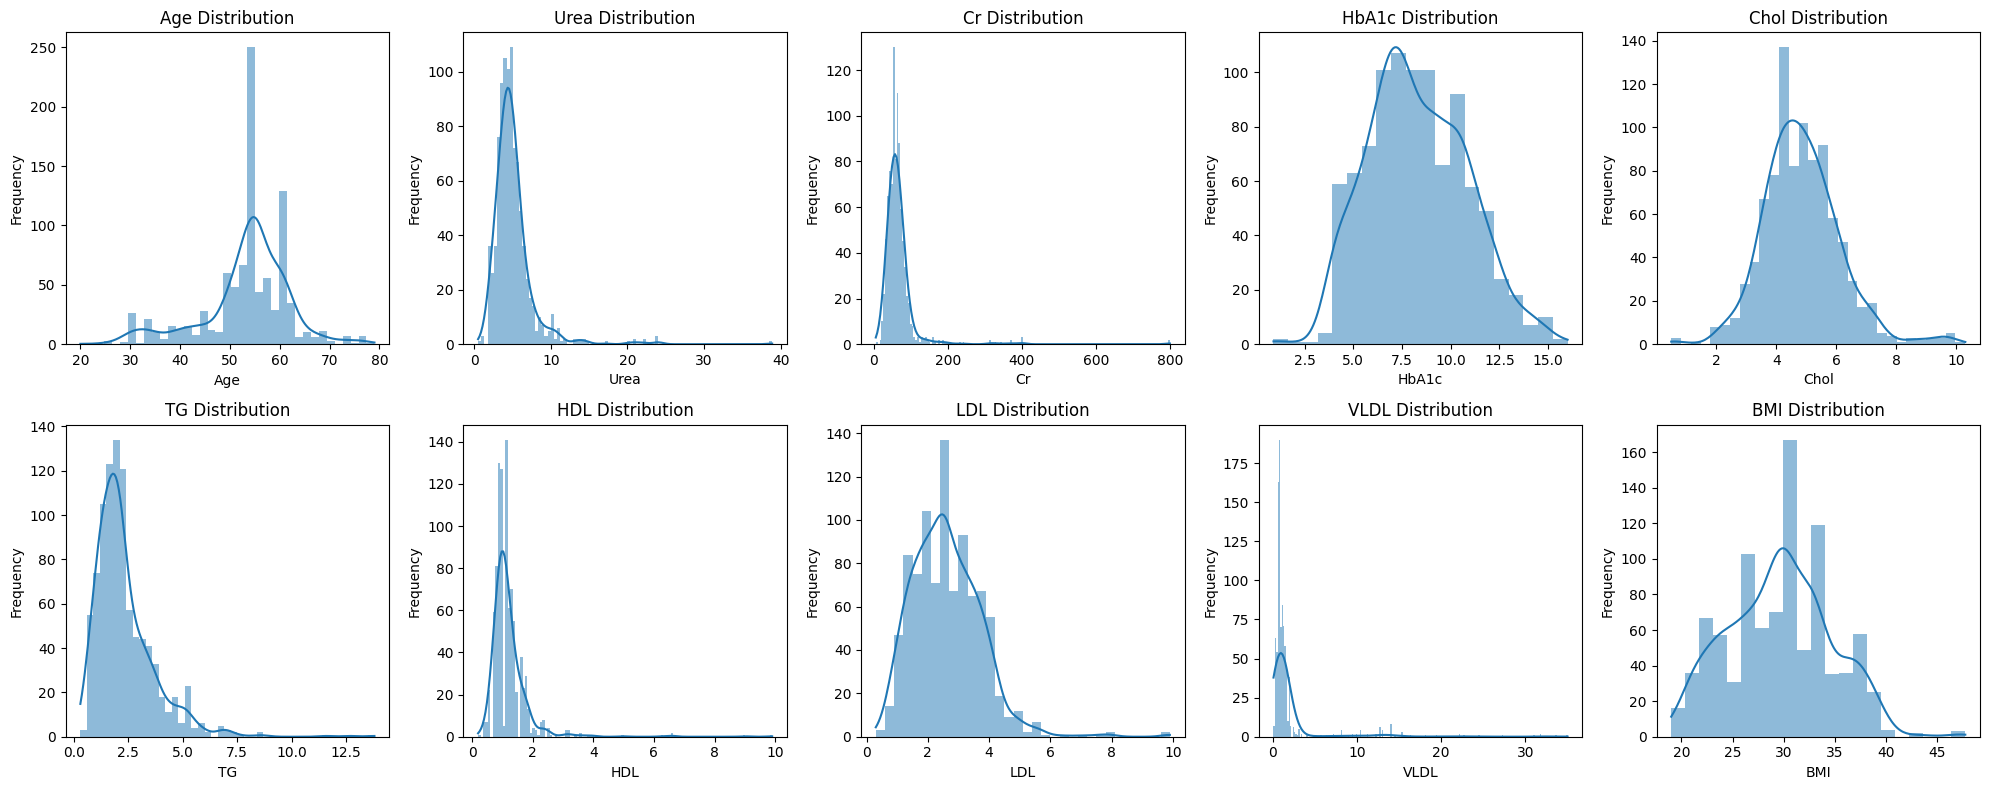

In [121]:
def plot_histograms(vars):
 
    # Create the figure
    fig, axes = plt.subplots(len(vars)//5, 5, figsize=(20, 8 if len(vars)>5 else 4))

    # Flatten the axes array for easier access
    axes = axes.flatten()

    # For each numerical variable
    for i, var in enumerate(vars):

        # Plot the histogram with a kernel density estimate
        sns.histplot(data[var], kde=True, edgecolor='none', ax=axes[i])

        # Set the labels and title
        axes[i].set_title(var + ' Distribution')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequency')

    # Adjust the layout
    plt.tight_layout()

    # Save the figure to SVG
    fig.savefig('figures/numerical_variables_distribution.svg')

    # Show the figure
    plt.show()


plot_histograms(numerical_vars)

### Feature engineering

Create new features that are mainly ratios of other features and based on the literature could be useful to identify diabetes and prediabetes

In [122]:
# TG / HDL
data['TG/HDL'] = data['TG'] / data['HDL']

# Chol / HDL
data['Chol/HDL'] = data['Chol'] / data['HDL']

# Non-HDL (Total - HDL)
data['Non-HDL'] = data['Chol'] - data['HDL']

# LDL / HDL
data['LDL/HDL'] = data['LDL'] / data['HDL']

# Urea / Cr
data['Urea/Cr'] = data['Urea'] / data['Cr']

# Show the first observations, including the new features
data.head()

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis,TG/HDL,Chol/HDL,Non-HDL,LDL/HDL,Urea/Cr
0,17975,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
1,34221,Male,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,Non-diabetes,1.272727,3.363636,2.6,1.909091,0.072581
2,47975,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
3,87656,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
4,34223,Male,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,Non-diabetes,1.250000,6.125000,4.1,2.500000,0.154348


Show the distribution of the new created features

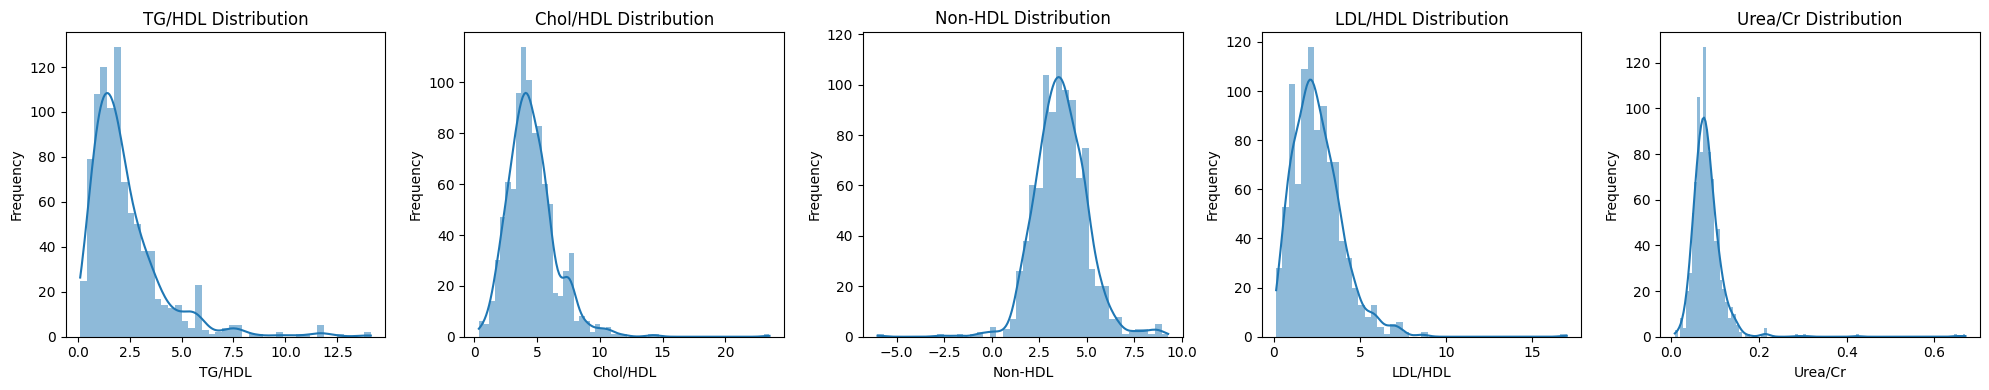

In [123]:
plot_histograms(data.columns[-5:])

### Encoding

Encode the categorical variables with a label encoder. There are only two categorical variables: sex (that is binary), and the diagnosis (with three categories). \
In the case of the diagnosis, all used models can deal with label-encoded target variables: SVC (with one-vs-rest and one-vs-one), XGBoost, LightGBM, AdaBoost, RandomForest and Neural Networks (with CrossEntropyLoss)

In [2]:
# Create a separate encoder for each variable
sex_encoder = LabelEncoder()
diagnosis_encoder = LabelEncoder()

# Encode the categorical variables
data['Sex'] = sex_encoder.fit_transform(data['Sex'])
data['Diagnosis'] = diagnosis_encoder.fit_transform(data['Diagnosis'])

# Print the mapping from labels to codes
sex_mapping = dict(zip(sex_encoder.classes_, sex_encoder.transform(sex_encoder.classes_)))
diagnosis_mapping = dict(zip(diagnosis_encoder.classes_, diagnosis_encoder.transform(diagnosis_encoder.classes_)))
print("Sex label mapping:", sex_mapping)
print("Diagnosis label mapping:", diagnosis_mapping)

Sex label mapping: {'Female': 0, 'Male': 1}
Diagnosis label mapping: {'Non-diabetes': 0, 'Prediabetes': 1, 'Diabetes': 2}


### Data split

Create two separate dataframes, one with HbA1C and another without it (only non-glycemic biomarkers)

In [25]:
# Create two dataframes, one with HbA1C and another without it
data_full = data_no_id.copy()
data_no_glycemic = data_no_id.drop('HbA1c', axis=1)

Split the data into features (X) and target (y), and into the training and testing sets. 20% of the data will be devoted to testing.

In [26]:
# Split the data into features and target
X = data_no_glycemic.drop('Diagnosis', axis=1)
y = data_no_glycemic['Diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
print(f"Nº observations for the training set: {X_train.shape[0]}")
print(f"Nº observations for the testing set: {X_test.shape[0]}")

Nº observations for the training set: 751
Nº observations for the testing set: 188


## Diabetes prediction (without HbA1c)

### Regular prediction

The data will be **scaled** between 0 and 1 using the **MinMax** scaler, so that it is prevented that the models (like SVM or neural network) give more importance to features with wider value ranges, as well as improving the convergence process of the algorithms.

As mentiones before, since some features were created with information from other features which lead to redundancy in the feature data (that could negatively affect models like SVM and neural network), **feature selection** will be applied, employing **Recursive Feature Elimination** (RFE) as the feature selection method, that will be based on the same model type (i.e. for SVC, the Recursive Feature Elimination will be based on a SVC model, for XGBoost it will be based on a XGBoost and so on).

For the diagnosis prediction, the following **models** will be used:
- Support Vector Machine (**SVM**)
- eXtreme Gradient Boosting (**XGBoost**)
- Light Gradient Boosting Machine (**LightGBM**)
- Adaptive Boosting (**AdaBoost**)
- **Random Forest**
- **Neural Network**

In order to improve the performance, **hyperparameter optimization** will be performed. **Bayesian optimization** (**Optuna**) will be utilized as the optimization method, since most of the hyperparameters of the used models are continuous and due to its high efficiency (which can achieve good results with low execution time). The performance will be computed with a **Stratified 5-Fold Cross-Validation**, in which the whole training set is split into 5 folds while keeping the same class proportion as the training set. 

Regarding the **performance metric**, as the target classes (diagnoses) are unbalanced, the main one will be the **macro average F1 score**, that will be used both for optimization (by maximizing the mean macro average F1 score of the 5 folds), as well as in the final performance assessment.

In order to avoid a data leakage and the validation is fair, the data will be passed through the scaling and feature selection in each fold of the cross-validation. Once the hyperparameters are optimized, the same pipeline is applied to the whole training set, so that the model is trained with as much information as possible.

For reproducibility, there will be 30 Optuna trials in the hyperparameter optimization, and the random state will always be the same: 42.

#### SVM

The hyperparameters to optimize in the SVM classifier, as well as their ranges are:
- **C** : [0.5, 200]
- **gamma** : [0.001, 1]
- **kernel**: *linear*, *poly*, *rbf*, or *sigmoid*
- **decision_function_shape**: *ovo* (one-vs-one), *ovr* (one-vs-rest)
- **degree**: [2, 6]

In [82]:
def log_hyperparameter_tuning_results(study):
    '''
    Function to log the hyperparameter tuning results
    '''
    print("Best hyperparameters:")
    for param, value in study.best_params.items():
        print(f" - {param}: {value}")
    print("F1-score with those hyperparameters in hyperparameter tuning:", study.best_value)


def log_selected_features(selected_features):
    '''
    Function to log the selected features in the features selection
    '''
    print('\nSelected features:')
    for feature in selected_features:
        print(f" - {feature}")


def build_pipeline(oversampling, scaler, rfe, model, seed=42):
    '''
    Function to create the pipeline with the sampling strategy (if present), scaler, feature selection and model
    '''
    sampler = None
    if oversampling:
        sampler = SMOTE(random_state=seed, sampling_strategy='not majority')
    steps = [('scaler', scaler), ('feature_selection', rfe), ('model', model)]
    if sampler:
        steps.insert(2, ('sampler', sampler))
    return ImbPipeline(steps)


def obj_func_SVC(trial, X_train, y_train, oversampling):
    '''
    Objective function for the hyperparameter optimization of the SVC model
    '''

    # Set the hyperparameters to optimize
    kernel = trial.suggest_categorical('svc__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    parameters = {
        'C': trial.suggest_float('svc__C', 0.5, 200),
        'gamma': trial.suggest_float('svc__gamma', 0.001, 1, log=True),
        'kernel': kernel,
        'decision_function_shape': trial.suggest_categorical('svc__decision_function_shape', ['ovo', 'ovr'])
    }
    if kernel == 'poly':
        parameters['degree'] = trial.suggest_int('svc__degree', 2, 6)
    
    # Create the SVM classifier
    model = SVC(**parameters)

    # Create the Recursive Feature Elimination (RFE) object with a SVM classifier
    rfe = RFECV(estimator=SVC(kernel='linear'), step=1, cv=StratifiedKFold(5), scoring='f1_macro')

    # Create the pipeline with the sampling strategy, the scaler, the feature selection and the model
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)
    
    # Return the mean cross-validated macro average F1-score
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    return np.mean(scores)


def opt_fit_svc(X_train, y_train, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optmize and train the SVM classifier
    '''

    # Create the Optuna study
    pte_sampler = optuna.samplers.TPESampler(seed=seed)
    optuna_study = optuna.create_study(direction='maximize', sampler=pte_sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    optuna_study.optimize(lambda trial: obj_func_SVC(trial, X_train, y_train, oversampling), n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    log_hyperparameter_tuning_results(optuna_study)
    
    # Create the final pipeline with the best hyperparameters
    opt_parameters = optuna_study.best_params
    model_parameters = {k.replace('svc__', ''): v for k, v in opt_parameters.items() if 'svc__' in k}
    model = SVC(**model_parameters)
    rfe = RFECV(estimator=SVC(kernel='linear'), step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Fit the final pipeline
    pipeline.fit(X_train, y_train)

    # Show the selected features
    selected_features = np.array(X_train.columns)[rfe.support_] if isinstance(X_train, pd.DataFrame) else np.where(rfe.support_)[0]
    log_selected_features(selected_features)

    return pipeline

    
# Do not show the information of each individual trial so that the output is not filled with too much information
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Perform hyperparameter optimization and create the final pipeline
pipeline_SVC = opt_fit_svc(X_train, y_train)

Best hyperparameters:
 - svc__kernel: rbf
 - svc__C: 113.89489311269335
 - svc__gamma: 0.12439733596259285
 - svc__decision_function_shape: ovo
F1-score with those hyperparameters in hyperparameter tuning: 0.6300481497115699

Selected features:
 - Sex
 - Age
 - Chol
 - TG
 - LDL
 - VLDL
 - BMI
 - TG/HDL
 - Non-HDL
 - LDL/HDL


For the final performance assessment, accuracy, precision, recall and the confusion matrix will be computed as well.

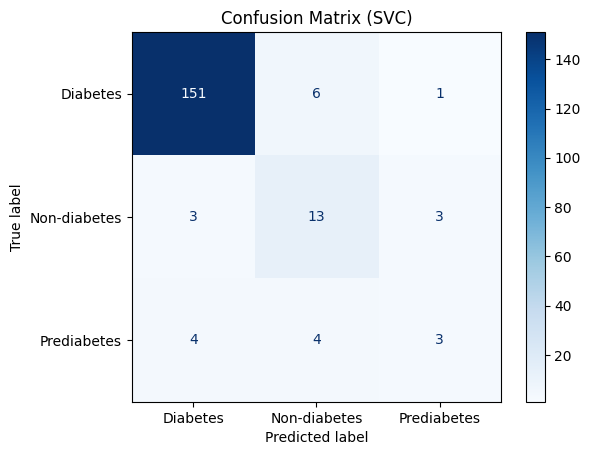

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.636026,0.888298,0.649828,0.637545


In [83]:
def evaluate_model(model, X_test, y_test, encoder, title='Confusion Matrix'):
    '''
    Function to evaluate the model
    '''

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Get the original labels from the encoder
    display_labels = encoder.inverse_transform(model.classes_)

    # Display the confusion matrix with original labels
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
    conf_matrix_display.plot(cmap='Blues')
    plt.title(title)
    plt.show()

    # Compute accuracy, and macro average precision, recall and F1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Create a DataFrame with the metrics
    metrics = {'Macro-average F1 Score': f1_macro, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    metrics = pd.DataFrame([metrics])

    return metrics


# Compute the performance metrics and show the confusion matrix
metrics_SVC = evaluate_model(pipeline_SVC, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (SVC)')
metrics_SVC

#### XGBoost

The hyperparameters to optimize in the XGBoost classifier, as well as their ranges are:
- **max_depth**: [3, 10]
- **learning_rate**: [0.01, 0.3]
- **n_estimators**: [10, 1000]
- **subsample**: [0.5, 1.0]
- **colsample_bytree**: [0.5, 1.0]
- **gamma**: [0, 5]
- **min_child_weight**: [1, 10]
- **reg_alpha**: [0.0, 1.0]
- **reg_lambda**: [1.0, 10.0]


In [28]:
def obj_XGB(trial, X_train, y_train, oversampling):
    '''
    Objective function for the hyperparameter optimization of the XGB classifier
    '''

    # Set the hyperparameters to optimize
    parameters = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0)
    }

    # Create the XGB classifier
    model = xgb.XGBClassifier(**parameters, use_label_encoder=False, eval_metric='mlogloss')

    # Create the Recursive Feature Elimination (RFE) object with the XGB classifier
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')

    # Create the pipeline with the sampling strategy, the scaler, the feature selection and the model
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)
    
    # Return the mean cross-validated macro average F1-score
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    return np.mean(scores)


def opt_fit_xgb(X_train, y_train, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optimize and train the XGB classifier
    '''

    # Create the Optuna study
    sampler = sampler=optuna.samplers.TPESampler(seed=seed)
    optuna_study = optuna.create_study(direction='maximize', sampler=sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    optuna_study.optimize(lambda trial: obj_XGB(trial, X_train, y_train, oversampling), n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    log_hyperparameter_tuning_results(optuna_study)

    # Create the final pipeline with the best hyperparameters
    opt_parameters = optuna_study.best_params
    model_parameters = {k: v for k, v in opt_parameters.items() if k not in ['n_features_to_select']}
    model = xgb.XGBClassifier(**model_parameters, use_label_encoder=False, eval_metric='mlogloss')
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Fit the final pipeline
    pipeline.fit(X_train, y_train)

    # Show the selected features
    selected_features = np.array(X_train.columns)[rfe.support_] if isinstance(X_train, pd.DataFrame) else np.where(rfe.support_)[0]
    log_selected_features(selected_features)

    return pipeline


# Perform hyperparameter optimization and create the final pipeline
pipeline_XGB = opt_fit_xgb(X_train, y_train)

Best hyperparameters:
 - max_depth: 10
 - learning_rate: 0.19879458291976249
 - n_estimators: 323
 - subsample: 0.9996812193207757
 - colsample_bytree: 0.9928026005220635
 - gamma: 0.12774747405271558
 - min_child_weight: 3
 - reg_alpha: 0.048380767807638586
 - reg_lambda: 9.990653651071458
F1-score with those hyperparameters in hyperparameter tuning: 0.8048007757277414

Selected features:
 - Sex
 - Age
 - Chol
 - TG
 - HDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Non-HDL
 - Urea/Cr


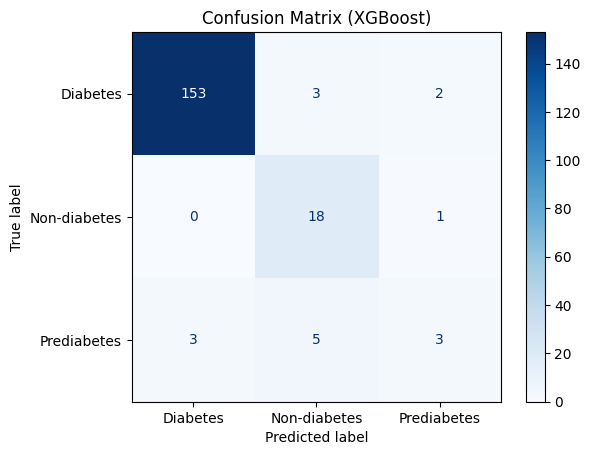

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.709154,0.925532,0.724359,0.729483


In [84]:
# Compute the performance metrics and show the confusion matrix
metrics_XGBoost = evaluate_model(pipeline_XGB, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (XGBoost)')
metrics_XGBoost

#### LightGBM

The hyperparameters to optimize in the XGBoost classifier, as well as their ranges are:
- **max_depth**: [3, 10]
- **learning_rate**: [0.01, 0.3]
- **n_estimators**: [10, 1000]
- **subsample**: [0.5, 1.0]
- **colsample_bytree**: [0.5, 1.0]
- **num_leaves**: [5, 50]
- **min_split_gain**: [0.01, 0.3]
- **min_child_weight**: [1, 10]
- **reg_alpha**: [0.0, 1.0]
- **reg_lambda**: [1.0, 10.0]


In [192]:
def obj_LGBM(trial, X_train, y_train, oversampling):
    '''
    Objective function for the hyperparameter optimization of the LightGBM classifier
    '''

    # Get the number of classes
    n_classes = len(np.unique(y_train))

    # Set the hyperparameters to optimize
    parameters = {
        'objective': 'multiclass',
        'num_class': n_classes,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.3),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'verbose': -1
    }

    # Create the LightGBM classifier
    model = lgb.LGBMClassifier(**parameters)

    # Create the Recursive Feature Elimination (RFE) object with the LightGBM classifier
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')

    # Create the pipeline with the sampling strategy, the scaler, the feature selection and the model
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Return the mean cross-validated macro average F1-score
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    return np.mean(scores)


def opt_fit_lgbm(X_train, y_train, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optimize and train the LightGBM classifier
    '''

    # Create the Optuna study
    sampler = optuna.samplers.TPESampler(seed=seed)
    optuna_study = optuna.create_study(direction='maximize', sampler=sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    optuna_study.optimize(lambda trial: obj_LGBM(trial, X_train, y_train, oversampling), n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    log_hyperparameter_tuning_results(optuna_study)

    # Create the final pipeline with the best hyperparameters
    opt_parameters = optuna_study.best_params
    model_parameters = {k: v for k, v in opt_parameters.items() if k not in ['n_features_to_select']}
    model = lgb.LGBMClassifier(**model_parameters)
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Fit the final pipeline
    pipeline.fit(X_train, y_train)

    # Show the selected features
    selected_features = np.array(X_train.columns)[rfe.support_] if isinstance(X_train, pd.DataFrame) else np.where(rfe.support_)[0]
    log_selected_features(selected_features)

    return pipeline


# Perform hyperparameter optimization and create the final pipeline
pipeline_LGBM = opt_fit_lgbm(X_train, y_train)

Best hyperparameters:
 - max_depth: 8
 - learning_rate: 0.2983201571423619
 - n_estimators: 263
 - subsample: 0.8356547159696401
 - colsample_bytree: 0.7995029565695583
 - num_leaves: 37
 - min_split_gain: 0.28183136504702233
 - min_child_weight: 4.166287916857318
 - reg_alpha: 0.253634097471396
 - reg_lambda: 4.622252581330957
F1-score with those hyperparameters in hyperparameter tuning: 0.7558684104477499

Selected features:
 - Age
 - Urea
 - Cr
 - Chol
 - TG
 - LDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Urea/Cr


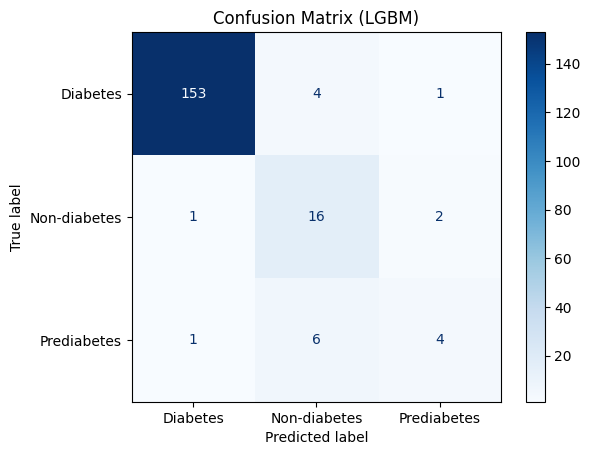

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.711064,0.920213,0.724637,0.724699


In [193]:
# Compute the performance metrics and show the confusion matrix
metrics_LGBM = evaluate_model(pipeline_LGBM, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (LGBM)')
metrics_LGBM

#### AdaBoost

The hyperparameters to optimize in the AdaBoost classifier, as well as their ranges are:
- **n_estimators**: [10, 1000]
- **learning_rate**: [0.05, 3.0]
- **estimator_max_depth**: [3, 10]


In [32]:
def obj_AdaBoost(trial, X_train, y_train, oversampling):
    '''
    Objective function for the hyperparameter optimization of the AdaBoost classifier
    '''

    # Set the hyperparameters to optimize
    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 3.0),
        'random_state': 42
    }
    estimator_max_depth = trial.suggest_int('estimator_max_depth', 3, 10)

    # Create the AdaBoost classifier
    individual_tree = DecisionTreeClassifier(max_depth=estimator_max_depth)  # Individual estimator of each tree in the AdaBoostClassifier
    model = AdaBoostClassifier(estimator=individual_tree, **parameters)
    
    # Create the Recursive Feature Elimination (RFE) object with the AdaBoost classifier
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')

    # Create the pipeline with the sampling strategy, the scaler, the feature selection and the model
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Return the mean cross-validated macro average F1-score
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    return np.mean(scores)


def opt_fit_AdaBoost(X_train, y_train, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optimize and train the AdaBoost classifier
    '''

    # Create the Optuna study
    sampler = optuna.samplers.TPESampler(seed=seed)
    optuna_study = optuna.create_study(direction='maximize', sampler=sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    optuna_study.optimize(lambda trial: obj_AdaBoost(trial, X_train, y_train, oversampling), n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    log_hyperparameter_tuning_results(optuna_study)

    # Create the final pipeline with the best hyperparameters
    opt_parameters = optuna_study.best_params
    estimator_max_depth = opt_parameters.pop('estimator_max_depth')
    individual_tree = DecisionTreeClassifier(max_depth=estimator_max_depth)
    model_parameters = {**opt_parameters, 'random_state': seed}
    model = AdaBoostClassifier(estimator=individual_tree, **model_parameters)
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Fit the final pipeline
    pipeline.fit(X_train, y_train)

    # Show the selected features
    selected_features = np.array(X_train.columns)[rfe.support_] if isinstance(X_train, pd.DataFrame) else np.where(rfe.support_)[0]
    log_selected_features(selected_features)

    return pipeline


# Perform hyperparameter optimization and create the final pipeline
pipeline_AdaBoost = opt_fit_AdaBoost(X_train, y_train)

Best hyperparameters:
 - n_estimators: 328
 - learning_rate: 1.8374660093873787
 - estimator_max_depth: 5
F1-score with those hyperparameters in hyperparameter tuning: 0.8476770009715242

Selected features:
 - Sex
 - Age
 - Cr
 - Chol
 - TG
 - VLDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - LDL/HDL


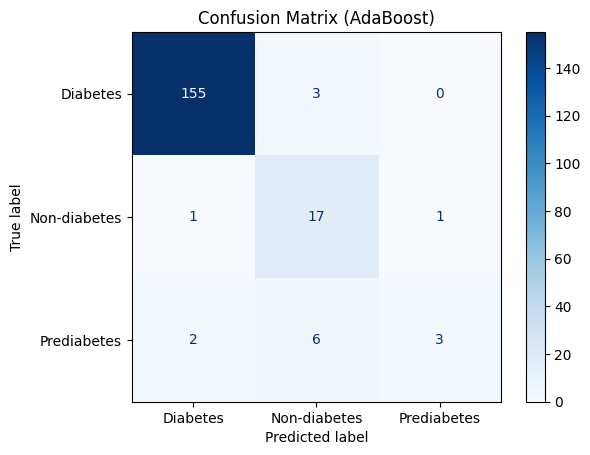

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.712189,0.930851,0.794953,0.716159


In [88]:
# Compute the performance metrics and show the confusion matrix
metrics_AdaBoost = evaluate_model(pipeline_AdaBoost, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (AdaBoost)')
metrics_AdaBoost

#### Random Forest

- **max_depth**: [3, 10]
- **n_estimators**: [10, 1000]
- **max_features**: *sqrt*, *log2*
- **min_samples_leaf**: [1, 10]
- **max_samples**: [0.5, 1.0]
- **criterion**: *gini*, *entropy*


In [177]:
def obj_func_RF(trial, X_train, y_train, oversampling, seed):
    '''
    Objective function for the hyperparameter optimization of the XGB classifier
    '''

    # Set the hyperparameters to optimize
    parameters = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': seed
    }

    # Create the Random Forest classifier
    model = RandomForestClassifier(**parameters)
    
    # Create the Recursive Feature Elimination (RFE) object with the Random Forest classifier
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')

    # Create the pipeline with the sampling strategy, the scaler, the feature selection and the model
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Return the mean cross-validated macro average F1-score
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    return np.mean(scores)


def opt_fit_rf(X_train, y_train, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optimize and train the XGB classifier
    '''
    
    # Create the Optuna study
    sampler = optuna.samplers.TPESampler(seed=seed)
    optuna_study = optuna.create_study(direction='maximize', sampler=sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    optuna_study.optimize(lambda trial: obj_func_RF(trial, X_train, y_train, oversampling, seed), n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    log_hyperparameter_tuning_results(optuna_study)

    # Create the final pipeline with the best hyperparameters
    opt_parameters = optuna_study.best_params
    model = RandomForestClassifier(**opt_parameters, random_state=42)
    rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    pipeline = build_pipeline(oversampling, MinMaxScaler(), rfe, model)

    # Fit the final pipeline
    pipeline.fit(X_train, y_train)

    # Show the selected features
    selected_features = np.array(X_train.columns)[rfe.support_] if isinstance(X_train, pd.DataFrame) else np.where(rfe.support_)[0]
    log_selected_features(selected_features)

    return pipeline


# Perform hyperparameter optimization and create the final pipeline
pipeline_RF = opt_fit_rf(X_train, y_train)

Best hyperparameters:
 - max_depth: 7
 - n_estimators: 117
 - max_features: log2
 - min_samples_leaf: 6
 - max_samples: 0.8188051220629968
 - criterion: entropy
F1-score with those hyperparameters in hyperparameter tuning: 0.6552778517510982

Selected features:
 - Age
 - Chol
 - TG
 - VLDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Non-HDL
 - LDL/HDL
 - Urea/Cr


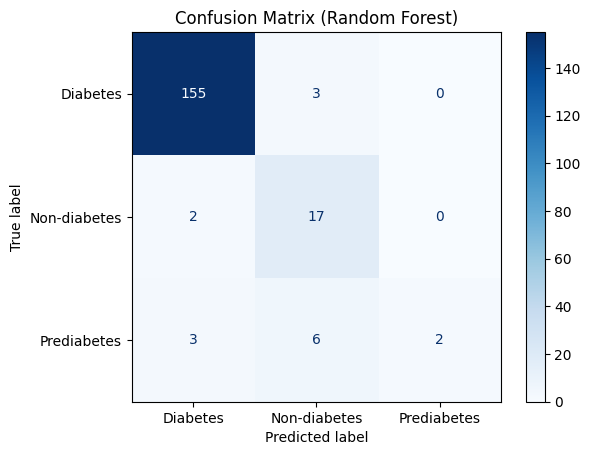

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.679364,0.925532,0.874199,0.685856


In [178]:
metrics_RF = evaluate_model(pipeline_RF, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (Random Forest)')
metrics_RF

#### Neural Network

The **architecture** of the neural network model consists of a **set of *steps***, which are **blocks** of **two linear layers** with **ReLU activations** (between hidden layers), with **batch normalization** after the first linear layer and a **dropout layer** between steps. The batch normalization is used to make the training process more stable and faster, whereas the droupout is used for preventing overfitting by randomly turnning off some outputs of the neurons between steps. The final layer of the model is a linear layer, so the outputs of the model are logits (raw output).

As in the other models, **Recursive Feature Elimination** will be utilized. However, the neural network does not provide in an easy manner the feature importances required for RFE. To deal with that, the feature selection will be **based on the gradients** (more precisely, the absolute sum of the gradients), as they reflect how changes in a feature impact the prediction of the model.

As the loss function, **cross-entropy loss** is used, which uses *softmax* activation (so there is no need to include it manually as the final activation function of the model), as well as *log likelihood* calculation. Also, **Adam** is used as the **optimizer**. As the batch size, 64 is used.

The **hyperparameters** to optimize are the following:
- **n_steps** (number of *steps* in the neural network): [1, 5]
- **n_units** (number of units in each layer): [5, 50]
- **lr** (learning rate for the Adam optimizer): [1e-4, 1e-2]
- **drop_out_rate** (rate to randomly turn off the output of neurons): [0, 0.2]

In [ ]:
def set_seeds(seed_value=42):
    '''
    Function to set the seeds for reproducibility
    '''
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class StepNetModel(nn.Module):
    '''
    Class to define a neural network with required steps, which are blocks of two linear layers with ReLU activations, with batch normalization after the first linear layer
    '''

    def __init__(self, input_dim, output_dim, n_steps, n_units, dropout_rate):
        '''
        Constructor of the neural network
        '''

        # Initialize the superclass
        super(StepNetModel, self).__init__()

        # Initialize a module list
        self.steps = nn.ModuleList()

        # For each step
        for i in range(n_steps):

            step = nn.Sequential(
                nn.Linear(input_dim, n_units),  # First linear layer
                nn.ReLU(),                      # ReLU activation function
                nn.BatchNorm1d(n_units),        # Batch normalization
                nn.Linear(n_units, n_units),    # Second linear layer
                nn.ReLU(),                      # ReLU activation function
                nn.Dropout(dropout_rate)        # Dropout layer between steps
            )

            # Append the step to the list
            self.steps.append(step)

            # Update the input dimension for the next step
            input_dim = n_units
        
        # Create the final layer to produce logits (raw output scores for each class) that will be managed by CrossEntropyLoss
        self.classifier = nn.Linear(n_units, output_dim)


    def forward(self, x):
        '''
        Processes the input tensor (x) through sequential network steps, and a classifier to produce final class logits
        '''

        # For each step
        for step in self.steps:

            # Apply the current step to the input and update the input for the next step
            x = step(x)
        
        # Apply the classifier to create final output logits
        return self.classifier(x)


def train_nn(model, optimizer, criterion, loader, n_iter):
    '''
    Function to train a neural network model
    '''

    # For each epoch
    for epoch in range(n_iter):

        # Set the training mode
        model.train()

        # For each batch
        for batch_x, batch_y in loader:

            # Clear previous gradients
            optimizer.zero_grad()

            # Compute model raw predictions (logits) with a forward pass through the model
            output = model(batch_x)

            # Calculate the loss (cross-entropy loss)
            loss = criterion(output, batch_y)

            # Backward pass to compute gradients
            loss.backward()

            # Update the model parameters
            optimizer.step()

    # Return the trained model
    return model


def create_and_train_model(X, y, n_steps, n_units, lr, n_iter, dropout_rate):
    '''
    Function to create and train a model
    '''

    # Initialize the model
    model = StepNetModel(input_dim=X.shape[1], output_dim=len(np.unique(y)), n_steps=n_steps, n_units=n_units, dropout_rate=dropout_rate)

    # Create the optimizer (Adam) and loss function (cross-entropy loss) objects
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Create a DataLoader for the training data
    dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).long())
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Return the trained model
    return train_nn(model, optimizer, criterion, loader, n_iter)


def feature_importance_gradients(model, X, y):
    '''
    Function to compute the gradients of the features, that are considered to reflect the feature importance of the neural network
    '''

    # Switch the model to evaluation mode
    model.eval()

    # Convert input data to tensor and activate gradient calculation
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)

    # Convert target to tensor
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    # Compute model raw predictions (logits) with a forward pass through the model
    outputs = model(X_tensor)

    # Calculate the cross-entropy loss
    loss = nn.CrossEntropyLoss()(outputs, y_tensor)

    # Reset model from previous gradients
    model.zero_grad()

    # Backward pass to compute gradients
    loss.backward()
    
    # Get the absolute sum of gradients by feature
    gradients = X_tensor.grad.abs().sum(axis=0).numpy()

    # Return the gradients, which are considered to reflect the feature importance
    return gradients


def select_features_cv(model, X, y, seed, n_splits=5):
    '''
    Function to select features based on their importance (absolute sum of gradients) using cross-validation
    '''

    feature_importances = np.zeros(X.shape[1])

    # Stratified 5-Fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # For each fold
    for train_index, _ in skf.split(X, y):

        # Get the training data
        X_train_fold = X[train_index]
        y_train_fold = y[train_index]

        # Get the feature importance based on the absolute value of the gradients
        gradients = feature_importance_gradients(model, X_train_fold, y_train_fold)

        # Add the feature importance
        feature_importances += gradients

    # Average the feature importances over the folds
    feature_importances /= n_splits

    # Order the features from highest to lowest importance
    important_indices = np.argsort(feature_importances)[::-1]

    best_f1_score = 0
    best_n_features = 0

    # For each number of features
    for n_features in range(1, X.shape[1] + 1):

        # Select the top n features
        selected_indices = important_indices[:n_features]
        X_selected = X[:, selected_indices]


        f1_scores = []

        # For each fold
        for train_index, val_index in skf.split(X_selected, y):

            # Split data into train and validation, and use the selected features
            X_train_fold, X_val_fold = X_selected[train_index], X_selected[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]

            # Train the model with the selected features
            model_selected = create_and_train_model(X_train_fold, y_train_fold, n_steps, n_units, lr, 30, dropout_rate)
            model_selected.eval()

            # There is no need to calculate gradients for validation
            with torch.no_grad():

                # Convert validation features to tensor format
                X_val_tensor = torch.tensor(X_val_fold).float()

                # Compute model raw predictions (logits) with a forward pass through the model
                predictions = model_selected(X_val_tensor)

                # Get the predicted targets
                _, predicted = torch.max(predictions, 1)

                # Compute the macro average F1 score
                f1 = f1_score(y_val_fold, predicted.numpy(), average='macro')

            f1_scores.append(f1)

        # Compute the mean F1 score
        mean_f1_score = np.mean(f1_scores)

        # If it is the best score, update the best number of features
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_n_features = n_features

    # Select the best number of features
    best_indices = important_indices[:best_n_features]
    X_reduced = X[:, best_indices]

    # Return the selected features set its indices
    return X_reduced, best_indices


def objective_nn(trial, X, y, oversampling, seed):
    '''
    Function to optimize the hyperparameters of a neural network model
    '''

    # Convert the feature and target data to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Set the hyperparameters to optimize
    n_steps = trial.suggest_int('n_steps', 1, 5)
    n_units = trial.suggest_int('n_units', 5, 50)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    dropout_rate = trial.suggest_float('dropout_rate', 0, 0.2)

    # Split the data into training and validation sets using Stratified K-Fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    f1_scores = []

    # For each fold
    for train_index, val_index in kf.split(X, y):

        # Split the data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Scale the input data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Create and train the model with 30 epochs
        model = create_and_train_model(X_train_scaled, y_train, n_steps, n_units, lr, 30, dropout_rate)
        model.eval()

        # Perform feature selection with training data and apply it to validation data
        X_train_selected, important_indices = select_features_cv(model, X_train, y_train, seed)
        X_val_selected = X_val_scaled[:, important_indices]

        # Apply oversampling if requested
        sampler = None
        if oversampling:
            sampler = SMOTE(random_state=seed, sampling_strategy='not majority')
            X_train_selected, y_train = sampler.fit_resample(X_train_selected, y_train)

        # Train the model with the selected features
        model_selected = create_and_train_model(X_train_selected, y_train, n_steps, n_units, lr, 30, dropout_rate)
        model_selected.eval()

        # Do not activate gradient calculation
        with torch.no_grad():

            # Convert validation features to tensor
            X_val_tensor = torch.tensor(X_val_selected).float()

            # Compute model raw predictions (logits) with a forward pass through the model
            predictions = model(X_val_tensor)

            # Get the predicted targets
            _, predicted = torch.max(predictions, 1)

            # Compute the macro average F1 score
            f1 = f1_score(y_val, predicted.numpy(), average='macro')

        # Append the macro average F1 score to the list
        f1_scores.append(f1)

    # Return the mean macro average F1 score between the folds
    return np.mean(f1_scores)


def opt_fit_nn(X, y, oversampling=False, num_trials=30, seed=42):
    '''
    Function to optimize the hyperparameters of a neural network model and train it
    '''

    # Set the seeds for reproducibility
    set_seeds(seed)

    # Conver the feature and target data to NumPy arrays
    X_array = np.array(X)
    y_array = np.array(y)

    # Create the Optuna study
    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction='maximize', sampler=sampler)

    # Perform the hyperparameter optimization by maximizing the macro average F1-score in cross-validation
    objective_with_data = lambda trial: objective_nn(trial, X_array, y_array, oversampling, seed)
    study.optimize(objective_with_data, n_trials=num_trials)

    # Show the best hyperparameters found and the F1-score obtained with them
    best_params = study.best_params
    log_hyperparameter_tuning_results(study)

    # Scale the input data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_array)

    # Train the final model using the best parameters found, using 30 epochs
    model_full = create_and_train_model(X_scaled, y_array, best_params['n_steps'], best_params['n_units'], best_params['lr'], 30, best_params['dropout_rate'])

    # Select the features based on their importance
    X_scaled_reduced, important_indices = select_features_cv(model_full, X_scaled, y_array, seed)

    # Show the selected features
    log_selected_features(X.columns[important_indices])

    # Apply oversampling if requested
    sampler = None
    if oversampling:
        sampler = SMOTE(random_state=seed, sampling_strategy='not majority')
        X_scaled_reduced, y_array = sampler.fit_resample(X_scaled_reduced, y_array)

    # Train the final model with more epochs (100 epochs)
    model_final = create_and_train_model(X_scaled_reduced, y_array, best_params['n_steps'], best_params['n_units'], best_params['lr'], 100, best_params['dropout_rate'])

    # Return the final trained model, as well as the scaler, selected feature indices, and the fitted resampler for the later model evaluation
    return model_final, scaler, important_indices



# Perform hyperparameter optimization
model_NN, scaler_NN, important_features_indices = opt_fit_nn(X_train, y_train)

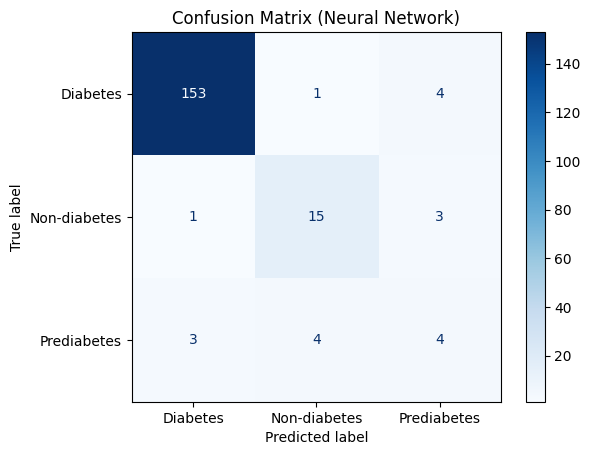

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.701432,0.914894,0.696053,0.707155


In [76]:
def evaluate_model_NN(model, X_test, y_test, scaler, important_features_indices, class_labels, title='Confusion Matrix'):
    '''
    Function to evaluate the neural network model
    '''

    # Convert the feature data to NumPy array
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()
    
    # Scale the test data with the already fitted scaler
    X_test_scaled = scaler.transform(X_test)

    # Select the same important features as used in the final model training
    X_test_scaled_reduced = X_test_scaled[:, important_features_indices]

    # Convert feature data to tensor for evaluation
    X_test_tensor = torch.tensor(X_test_scaled_reduced, dtype=torch.float32)

    # Enable the evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(X_test_tensor)              # Compute model raw predictions (logits) with a forward pass through the model
        _, y_pred_tensor = torch.max(outputs, 1)    # Get the predicted targets
        y_pred = y_pred_tensor.numpy()              # Convert the predicted targets to a NumPy array

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Get original class labels from the encoder by applyting an inverse transform
    display_labels = class_labels.inverse_transform(np.unique(y_test))

    # Display the confusion matrix with original labels
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
    conf_matrix_display.plot(cmap='Blues')
    plt.title(title)
    plt.show()

    # Compute the performance metrics
    f1_macro = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # Return a dataframe with the performance metrics
    metrics = {
        'Macro-average F1 Score': f1_macro,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    return pd.DataFrame([metrics])


# Compute the performance metrics and show the confusion matrix
metrics_NN = evaluate_model_NN(model_NN, X_test, y_test, scaler_NN, selected_features_NN, diagnosis_encoder, title='Confusion Matrix (Neural Network)')
metrics_NN

In [195]:
def make_comparison_table(dataframes, model_names):
    '''
    Function to make a comparison table of the performance obtained with each model
    '''

    # For each  model, set its model name
    for df, name in zip(dataframes, model_names):
        df['Model'] = name
    
    # Concatenate all the performance metric dataframes
    final_metrics = pd.concat(dataframes, ignore_index=True)

    # Reorder the columns to have the model name in the first column
    cols = ['Model'] + [col for col in final_metrics.columns if col != 'Model']
    final_metrics = final_metrics[cols]

    # Return the comparison table after sorting from highest to lowest macro average F1-score
    final_metrics = final_metrics.sort_values(by='Macro-average F1 Score', ascending=False)
    return final_metrics


# Create the comparison table with the performance metrics of all models
performance_tables = [metrics_NN, metrics_RF, metrics_AdaBoost, metrics_LGBM, metrics_XGBoost, metrics_SVC]
model_names = ['NN', 'RF', 'AdaBoost', 'LGBM', 'XGBoost', 'SVC']
performance_metrics_non_glycemic = make_comparison_table(performance_tables, model_names)
performance_metrics_non_glycemic

,Model,Macro-average F1 Score,Accuracy,Precision,Recall
1,AdaBoost,0.712189,0.930851,0.794953,0.716159
0,LGBM,0.711064,0.920213,0.724637,0.724699
2,XGBoost,0.709154,0.925532,0.724359,0.729483
3,NN,0.701432,0.914894,0.696053,0.707155
4,RF,0.679364,0.925532,0.874199,0.685856
5,SVC,0.636026,0.888298,0.649828,0.637545


### Oversampling

Since the target **classes** are **very unbalanced**, it may happen that the models, having more data for the class that appears most frequently (in this case, diabetes), focus too much on learning the patterns of this class or obtain a high accuracy value simply by always predicting the most majority class. To avoid this and try to improve the prediction of the models, ***SMOTE*** (Synthetic Minority Over-sampling Technique) has been used, which consists of generating synthetic samples of the minority class.

The **not majority strategy** has been used, which consists of generating synthetic samples of any class that is not the majority (in this case, without diabetes and prediabetes) until the number of classes of the majority class (diabetes) is reached. In this way, models can learn more patterns from the least represented classes and not overfit on the patterns of the class that appears most frequently.

In [163]:
pipeline_SVC = opt_fit_svc(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - svc__kernel: rbf
 - svc__C: 141.1780122095214
 - svc__gamma: 0.3600830598614627
 - svc__decision_function_shape: ovr
F1-score with those hyperparameters in hyperparameter tuning: 0.6900521651263616

Selected features:
 - Age
 - Urea
 - Chol
 - TG
 - HDL
 - LDL
 - VLDL
 - BMI
 - Non-HDL
 - LDL/HDL


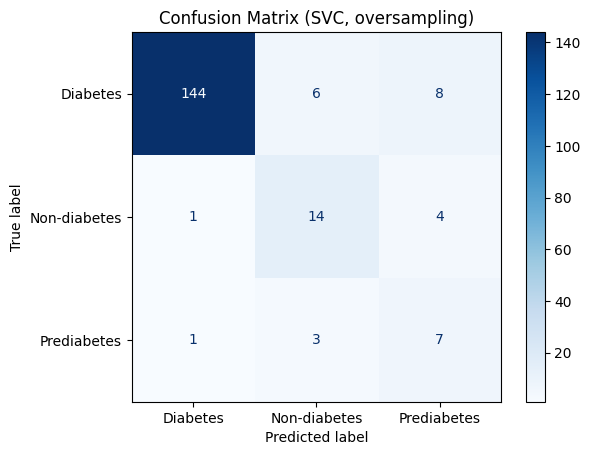

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.693567,0.87766,0.654473,0.761533


In [164]:
metrics_SVC_oversampling = evaluate_model(pipeline_SVC, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (SVC, oversampling)')
metrics_SVC_oversampling

In [1]:
pipeline_XGB = opt_fit_xgb(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 8
 - learning_rate: 0.21298640710858627
 - n_estimators: 406
 - subsample: 0.6198250039202166
 - colsample_bytree: 0.8578845866218715
 - gamma: 0.04376280468406657
 - min_child_weight: 3
 - reg_alpha: 0.18913436787920057
 - reg_lambda: 6.906358586383682
F1-score with those hyperparameters in hyperparameter tuning: 0.7972993466001539

Selected features:
 - Sex
 - Age
 - Cr
 - Chol
 - TG
 - LDL
 - VLDL
 - BMI
 - TG/HDL
 - Non-HDL


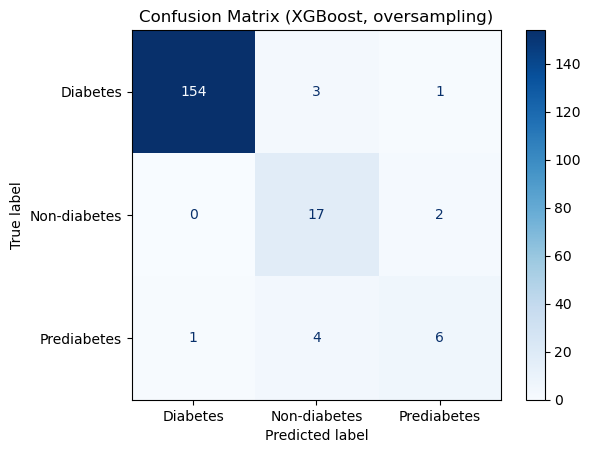

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.791574,0.941489,0.789516,0.804958


In [30]:
metrics_XGBoost_oversampling = evaluate_model(pipeline_XGB, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (XGBoost, oversampling)')
metrics_XGBoost_oversampling

In [167]:
pipeline_LGBM = opt_fit_lgbm(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 8
 - learning_rate: 0.12447792433398618
 - n_estimators: 957
 - subsample: 0.8619129192708
 - colsample_bytree: 0.7263625066390218
 - num_leaves: 50
 - min_split_gain: 0.013810691558164445
 - min_child_weight: 3.7310167079970222
 - reg_alpha: 0.18866823893765744
 - reg_lambda: 7.289201498771879
F1-score with those hyperparameters in hyperparameter tuning: 0.8031352202658459

Selected features:
 - Age
 - Urea
 - Cr
 - Chol
 - LDL
 - VLDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Urea/Cr


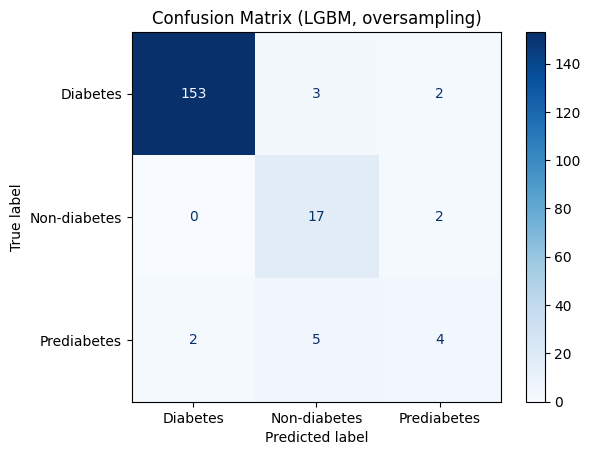

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.723805,0.925532,0.722366,0.742243


In [168]:
metrics_LGBM_oversampling = evaluate_model(pipeline_LGBM, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (LGBM, oversampling)')
metrics_LGBM_oversampling

In [169]:
pipeline_AdaBoost = opt_fit_AdaBoost(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - n_estimators: 207
 - learning_rate: 1.9071441177111021
 - estimator_max_depth: 9
F1-score with those hyperparameters in hyperparameter tuning: 0.8195685013278249

Selected features:
 - Sex
 - Age
 - Cr
 - Chol
 - TG
 - HDL
 - LDL
 - BMI
 - TG/HDL
 - Non-HDL


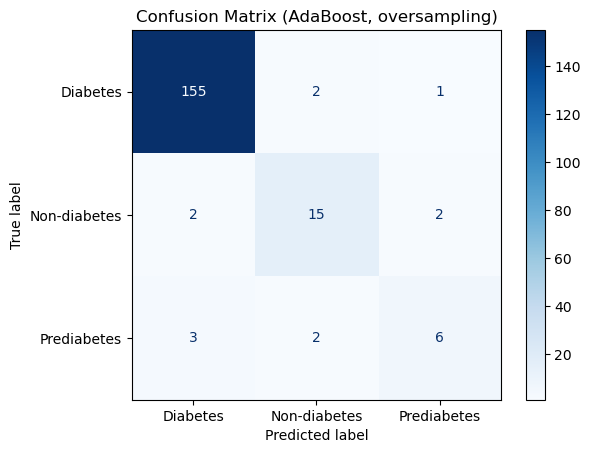

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.788105,0.93617,0.808297,0.77198


In [47]:
metrics_AdaBoost_oversampling = evaluate_model(pipeline_AdaBoost, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (AdaBoost, oversampling)')
metrics_AdaBoost_oversampling

In [139]:
pipeline_RF = opt_fit_rf(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 9
 - n_estimators: 715
 - max_features: log2
 - min_samples_leaf: 1
 - max_samples: 0.7287865909242692
 - criterion: entropy
F1-score with those hyperparameters in hyperparameter tuning: 0.7808625952401125

Selected features:
 - Age
 - Urea
 - Chol
 - TG
 - LDL
 - VLDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Non-HDL


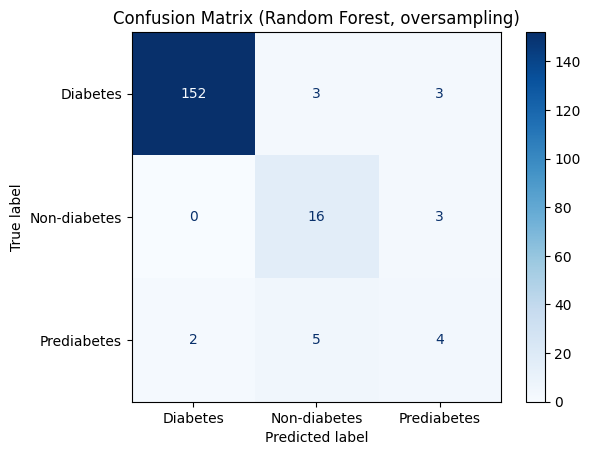

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.699832,0.914894,0.68456,0.722589


In [141]:
metrics_RF_oversampling = evaluate_model(pipeline_RF, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (Random Forest, oversampling)')
metrics_RF_oversampling

In [88]:
model_NN, scaler_NN, important_features_indices = opt_fit_nn(X_train, y_train, n_features_to_select=n_features_to_select, oversampling=True)

Best hyperparameters:
 - n_steps: 2
 - n_units: 48
 - lr: 0.007346740023932911
 - dropout_rate: 0.11973169683940732
F1-score with those hyperparameters in hyperparameter tuning: 0.7436655019928422

Selected features:
 - Age
 - LDL
 - Cr
 - VLDL
 - Chol
 - Urea
 - Chol/HDL
 - TG
 - BMI
 - Urea/Cr


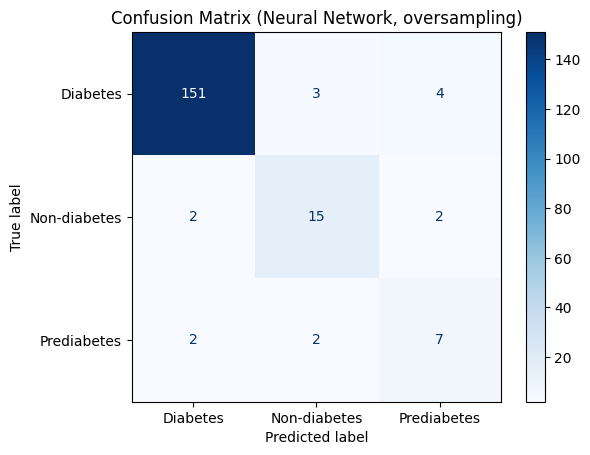

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.772473,0.920213,0.754218,0.793845


In [89]:
metrics_NN_oversampling = evaluate_model_NN(model_NN, X_test, y_test, scaler_NN, important_features_indices, diagnosis_encoder, title='Confusion Matrix (Neural Network, oversampling)')
metrics_NN_oversampling

In [5]:
performance_tables = [metrics_NN_oversampling, metrics_RF_oversampling, metrics_AdaBoost_oversampling, metrics_LGBM_oversampling, metrics_XGBoost_oversampling, metrics_SVC_oversampling]
model_names = ['NN', 'RF', 'AdaBoost', 'LGBM', 'XGBoost', 'SVC']
performance_metrics_non_glycemic_oversampling = make_comparison_table(performance_tables, model_names)
performance_metrics_non_glycemic_oversampling

,Model,Macro-average F1 Score,Accuracy,Precision,Recall
0,XGBoost,0.791574,0.941489,0.789516,0.804958
1,AdaBoost,0.788105,0.936170,0.808297,0.771980
2,NN,0.772473,0.920213,0.754218,0.793845
3,LGBM,0.723805,0.925532,0.722366,0.742243
4,RF,0.699832,0.914894,0.684560,0.722589
5,SVC,0.693567,0.877660,0.654473,0.761533


## Diabetes prediction (with HbA1c)

### Data split

In [39]:
# Split the data into features (X) and target (y)
X = data_full.drop('Diagnosis', axis=1)
y = data_full['Diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Prediction with oversampling

In [178]:
pipeline_SVC = opt_fit_svc(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - svc__kernel: rbf
 - svc__C: 198.20992945940483
 - svc__gamma: 0.1642604441500902
 - svc__decision_function_shape: ovr
F1-score with those hyperparameters in hyperparameter tuning: 0.8459163547421367

Selected features:
 - Age
 - Urea
 - HbA1c
 - Chol
 - TG
 - HDL
 - VLDL
 - BMI
 - Non-HDL
 - LDL/HDL


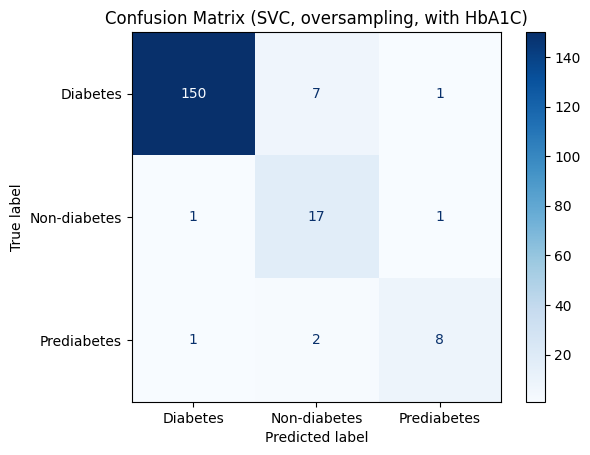

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.828401,0.930851,0.813563,0.857126


In [179]:
metrics_SVC_oversampling_glycemic = evaluate_model(pipeline_SVC, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (SVC, oversampling, with HbA1C)')
metrics_SVC_oversampling_glycemic

In [180]:
pipeline_XGB = opt_fit_xgb(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 5
 - learning_rate: 0.09147100780934041
 - n_estimators: 547
 - subsample: 0.5704621124873813
 - colsample_bytree: 0.9010984903770198
 - gamma: 0.3727532183988541
 - min_child_weight: 10
 - reg_alpha: 0.7722447692966574
 - reg_lambda: 2.7884411338075514
F1-score with those hyperparameters in hyperparameter tuning: 0.9483516365785423

Selected features:
 - Age
 - Cr
 - HbA1c
 - Chol
 - TG
 - LDL
 - BMI
 - TG/HDL
 - Chol/HDL
 - Non-HDL


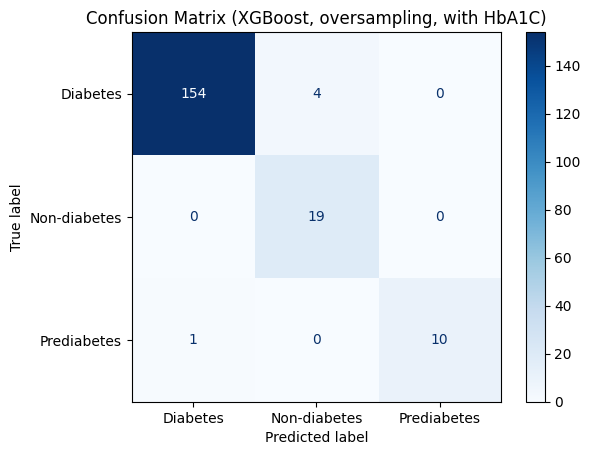

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.947056,0.973404,0.939878,0.961258


In [181]:
metrics_XGBoost_oversampling_glycemic = evaluate_model(pipeline_XGB, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (XGBoost, oversampling, with HbA1C)')
metrics_XGBoost_oversampling_glycemic

In [182]:
pipeline_LGBM = opt_fit_lgbm(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 9
 - learning_rate: 0.22628667614932196
 - n_estimators: 479
 - subsample: 0.7300427696336602
 - colsample_bytree: 0.9891800013671278
 - num_leaves: 19
 - min_split_gain: 0.13600857381451945
 - min_child_weight: 1.2586349674248964
 - reg_alpha: 0.10894084714397534
 - reg_lambda: 1.9134949579227434
F1-score with those hyperparameters in hyperparameter tuning: 0.9597928975873969

Selected features:
 - Age
 - HbA1c
 - Chol
 - TG
 - HDL
 - VLDL
 - BMI
 - TG/HDL
 - Non-HDL
 - LDL/HDL


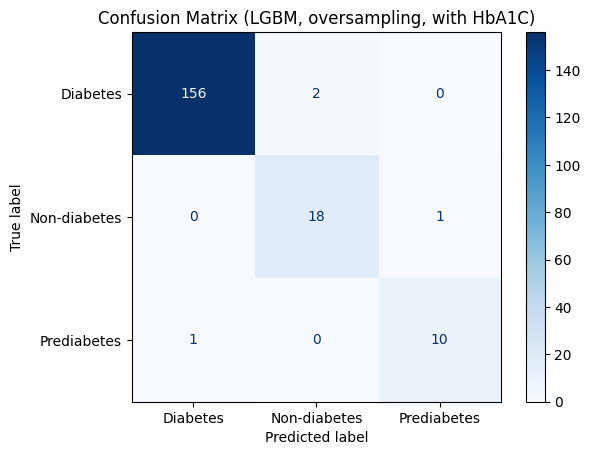

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.940881,0.978723,0.93424,0.947934


In [183]:
metrics_LGBM_oversampling_glycemic = evaluate_model(pipeline_LGBM, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (LGBM, oversampling, with HbA1C)')
metrics_LGBM_oversampling_glycemic

In [201]:
pipeline_AdaBoost = opt_fit_AdaBoost(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - n_estimators: 307
 - learning_rate: 1.3622705082630662
 - estimator_max_depth: 5
F1-score with those hyperparameters in hyperparameter tuning: 0.9583219396467644

Selected features:
 - Age
 - HbA1c
 - Chol
 - TG
 - LDL
 - BMI
 - Chol/HDL
 - Non-HDL
 - LDL/HDL
 - Urea/Cr


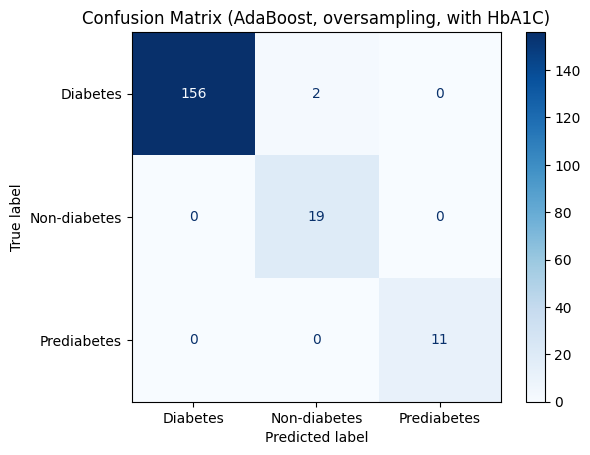

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.98121,0.989362,0.968254,0.995781


In [202]:
metrics_AdaBoost_oversampling_glycemic = evaluate_model(pipeline_AdaBoost, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (AdaBoost, oversampling, with HbA1C)')
metrics_AdaBoost_oversampling_glycemic

In [186]:
pipeline_RF = opt_fit_rf(X_train, y_train, n_features_to_select, oversampling=True)

Best hyperparameters:
 - max_depth: 10
 - n_estimators: 15
 - max_features: sqrt
 - min_samples_leaf: 1
 - max_samples: 0.6921738939279434
 - criterion: entropy
F1-score with those hyperparameters in hyperparameter tuning: 0.9531582668907774

Selected features:
 - Age
 - Urea
 - HbA1c
 - Chol
 - TG
 - LDL
 - BMI
 - TG/HDL
 - Non-HDL
 - LDL/HDL


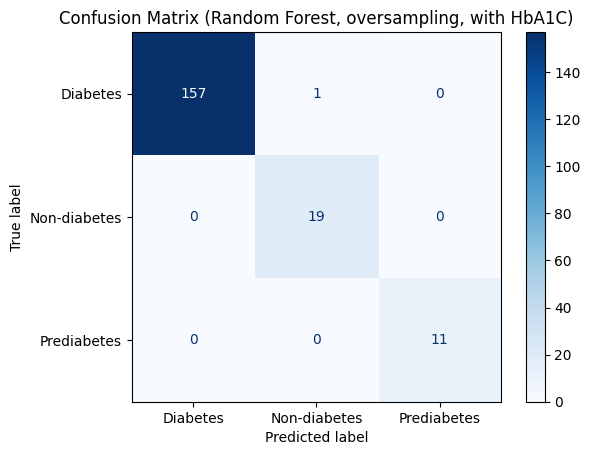

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.990395,0.994681,0.983333,0.99789


In [187]:
metrics_RF_oversampling_glycemic = evaluate_model(pipeline_RF, X_test, y_test, diagnosis_encoder, title='Confusion Matrix (Random Forest, oversampling, with HbA1C)')
metrics_RF_oversampling_glycemic

In [93]:
model_NN, scaler_NN, important_features_indices = opt_fit_nn(X_train, y_train, n_features_to_select=n_features_to_select, oversampling=True)

Best hyperparameters:
 - n_steps: 3
 - n_units: 36
 - lr: 0.0071481752057025415
 - dropout_rate: 0.15857567343391962
F1-score with those hyperparameters in hyperparameter tuning: 0.8792139648354625

Selected features:
 - VLDL
 - Chol
 - Age
 - Urea/Cr
 - TG
 - Non-HDL
 - LDL/HDL
 - HDL
 - BMI
 - HbA1c


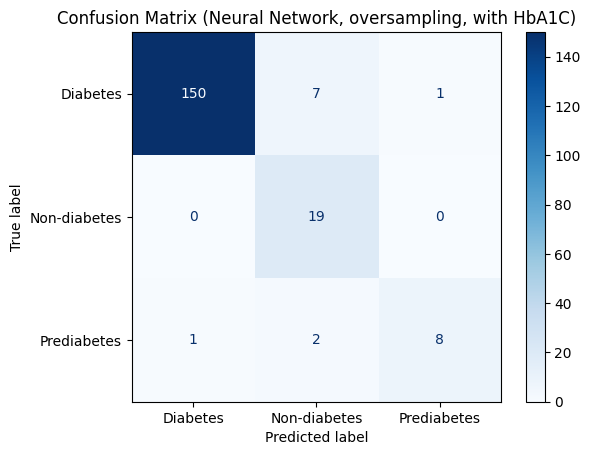

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.859795,0.941489,0.853613,0.892213


In [94]:
metrics_NN_oversampling_glycemic = evaluate_model_NN(model_NN, X_test, y_test, scaler_NN, important_features_indices, diagnosis_encoder, title='Confusion Matrix (Neural Network, oversampling, with HbA1C)')
metrics_NN_oversampling_glycemic

In [205]:
performance_tables = [metrics_NN_oversampling_glycemic, metrics_RF_oversampling_glycemic, metrics_AdaBoost_oversampling_glycemic, metrics_LGBM_oversampling_glycemic, metrics_XGBoost_oversampling_glycemic, metrics_SVC_oversampling_glycemic]
model_names = ['NN', 'RF', 'AdaBoost', 'LGBM', 'XGBoost', 'SVC']
performance_metrics_glycemic_oversampling = make_comparison_table(performance_tables, model_names)
performance_metrics_glycemic_oversampling

,Model,Macro-average F1 Score,Accuracy,Precision,Recall
0,RF,0.990395,0.994681,0.983333,0.997890
2,AdaBoost,0.981210,0.989362,0.968254,0.995781
1,XGBoost,0.947056,0.973404,0.939878,0.961258
3,LGBM,0.940881,0.978723,0.934240,0.947934
4,NN,0.859795,0.941489,0.853613,0.892213
5,SVC,0.828401,0.930851,0.813563,0.857126
